In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors
from copy import deepcopy

from rashomon import hasse, counter

%matplotlib inline

# Read data

In [25]:
profiles, profiles_map = hasse.enumerate_profiles(4)
profile_cols = [str(x) for x in profiles]
best_profile = (1, 0, 1, 0)
best_profile_idx = profiles_map[best_profile]
true_best_profile = str(best_profile)

In [34]:
# fname_csv = "../Results/reff_simulations_rashomon_25_100.csv"
# fname_csv = "../Results/reff_simulations_rashomon_25_100.csv"
# fname_csv = "../Results/reff_simulations_var_1_rashomon_10_100.csv"
fname_prefix = "4arms_"
fname_suffix = "_30_50_var_1.5.csv"
lasso_fname_suffix = "_30_100.csv"
ct_fname_suffix = "_30_100.csv"
blasso_fname_suffix = "_30_100.csv"
bootstrap_fname_suffix = "_30_100.csv"

## Rashomon

In [27]:

rashomon_fname_csv = "../Results/" + fname_prefix + "rashomon" + fname_suffix
rashomon_raw_df = pd.read_csv(rashomon_fname_csv)
rashomon_raw_df = rashomon_raw_df.drop("Unnamed: 0", axis=1)

# rashomon_raw_df.head()

rashomon_df = rashomon_raw_df.copy()

# compute the loss
reg = 1e-1
rashomon_df["loss"] = rashomon_df["MSE"] + reg * rashomon_df["num_pools"]

# Find whether each model identifies the true best profile or not
rashomon_df["right_best_profile"] = rashomon_df[true_best_profile]
rashomon_df["wrong_best_profile"] = 1 - rashomon_df["right_best_profile"]

# Remove all other columns
to_drop = ["num_pools", "MSE", "IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
rashomon_df = rashomon_df.drop(to_drop, axis=1)
# rashomon_df = rashomon_df.drop(profile_cols, axis=1)

# Sort loss grouped by n_per_pol and sim_num
rashomon_df = rashomon_df.sort_values(["n_per_pol", "sim_num", "loss"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = rashomon_df.groupby(["n_per_pol", "sim_num"]).cumsum()
rashomon_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
rashomon_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(rashomon_df))

rashomon_df.head(n=10)

82994


,n_per_pol,sim_num,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)","(0, 1, 0, 1)","(0, 1, 1, 0)","(0, 1, 1, 1)",...,"(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",loss,right_best_profile,wrong_best_profile,best_profile_present,model_number
0,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.613560,1,0,1,1
63,30,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2.712200,0,1,1,2
64,30,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2.712964,0,1,1,3
39,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713107,1,0,1,4
35,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713179,1,0,1,5
40,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713201,1,0,1,6
15,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713225,1,0,1,7
41,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713253,1,0,1,8
1,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713254,1,0,1,9
31,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.713270,1,0,1,10


In [28]:
sims_failing = pd.unique(rashomon_df[rashomon_df["best_profile_present"] == 0]["sim_num"])
never_reaching = []
for sim in sims_failing:
    if 1 not in pd.unique(rashomon_df[rashomon_df["sim_num"] == sim][true_best_profile]):
        never_reaching.append(sim)

print(never_reaching)
# for sim in never_reaching:
#     print(rashomon_df[rashomon_df["sim_num"] == sim]["loss"])

[]


## Lasso

In [29]:
lasso_fname_csv = "../Results/" + fname_prefix + "lasso" + lasso_fname_suffix
lasso_raw_df = pd.read_csv(lasso_fname_csv)
lasso_raw_df = lasso_raw_df.drop("Unnamed: 0", axis=1)

# lasso_raw_df.head()

lasso_df = lasso_raw_df.copy()

# Find whether each model identifies the true best profile or not
lasso_df["right_best_profile"] = lasso_df[true_best_profile]
lasso_df["wrong_best_profile"] = 1 - lasso_df["right_best_profile"]

# Remove all other columns
to_drop = ["MSE", "IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]

lasso_df = lasso_df.drop(to_drop, axis=1)

# Sort loss grouped by n_per_pol and sim_num
lasso_df = lasso_df.sort_values(["n_per_pol", "sim_num", "L1_loss"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = lasso_df.groupby(["n_per_pol", "sim_num"]).cumsum()
lasso_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# lasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(lasso_df))

lasso_df.head(n=10)

100


,n_per_pol,sim_num,L1_loss,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)","(0, 1, 0, 1)","(0, 1, 1, 0)",...,"(1, 0, 0, 1)","(1, 0, 1, 0)","(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",right_best_profile,wrong_best_profile,best_profile_present
0,30,0,3.088915,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,30,1,3.138726,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,30,2,3.110359,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,30,3,3.132916,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,30,4,3.129711,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5,30,5,3.156345,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
6,30,6,3.093533,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
7,30,7,3.129408,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
8,30,8,3.166789,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,30,9,3.161159,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


## Causal Trees

In [30]:
ct_fname_csv = "../Results/" + fname_prefix + "ct" + ct_fname_suffix
ct_raw_df = pd.read_csv(ct_fname_csv)
ct_raw_df = ct_raw_df.drop("Unnamed: 0", axis=1)

# lasso_raw_df.head()

ct_df = ct_raw_df.copy()

# Find whether each model identifies the true best profile or not
# true_best_profile = "(1, 0, 1)"
ct_df["right_best_profile"] = ct_df[true_best_profile]
ct_df["wrong_best_profile"] = 1 - ct_df["right_best_profile"]

# Remove all other columns
to_drop = ["IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]
ct_df = ct_df.drop(to_drop, axis=1)

# Sort loss grouped by n_per_pol and sim_num
ct_df = ct_df.sort_values(["n_per_pol", "sim_num", "MSE"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = ct_df.groupby(["n_per_pol", "sim_num"]).cumsum()
ct_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# lasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(ct_df))

ct_df.head(n=10)

100


,n_per_pol,sim_num,MSE,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)","(0, 1, 0, 1)","(0, 1, 1, 0)",...,"(1, 0, 0, 1)","(1, 0, 1, 0)","(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",right_best_profile,wrong_best_profile,best_profile_present
0,30,0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,30,1,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,30,2,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,30,3,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,30,4,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
5,30,5,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
6,30,6,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,30,7,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
8,30,8,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
9,30,9,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


## Bayesian Lasso

In [31]:
blasso_fname_csv = "../Results/" + fname_prefix + "blasso" + blasso_fname_suffix
blasso_raw_df = pd.read_csv(blasso_fname_csv)
blasso_raw_df = blasso_raw_df.drop("Unnamed: 0", axis=1)

# blasso_raw_df.head()
blasso_df = blasso_raw_df.copy()

# Find whether each model identifies the true best profile or not
blasso_df["right_best_profile"] = blasso_df[true_best_profile]
blasso_df["wrong_best_profile"] = 1 - blasso_df["right_best_profile"]

# Remove all other columns
to_drop = ["MSE", "IOU", "min_dosage", "best_pol_diff", "converged", "max_rhat"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]

blasso_df = blasso_df.drop(to_drop, axis=1)
# Sort loss grouped by n_per_pol and sim_num
blasso_df = blasso_df.sort_values(["n_per_pol", "sim_num"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = blasso_df.groupby(["n_per_pol", "sim_num"]).cumsum()
blasso_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# blasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(blasso_df))

lasso_df.head(n=10)

100


,n_per_pol,sim_num,L1_loss,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)","(0, 1, 0, 1)","(0, 1, 1, 0)",...,"(1, 0, 0, 1)","(1, 0, 1, 0)","(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",right_best_profile,wrong_best_profile,best_profile_present
0,30,0,3.088915,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,30,1,3.138726,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,30,2,3.110359,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,30,3,3.132916,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,30,4,3.129711,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5,30,5,3.156345,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
6,30,6,3.093533,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
7,30,7,3.129408,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
8,30,8,3.166789,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,30,9,3.161159,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


## Bootstrap

In [35]:
bootstrap_fname_suffix = "../Results/" + fname_prefix + "bootstrap" + bootstrap_fname_suffix
bootstrap_raw_df = pd.read_csv(bootstrap_fname_suffix)
bootstrap_raw_df = bootstrap_raw_df.drop("Unnamed: 0", axis=1)

# bootstrap_raw_df.head()
bootstrap_df = bootstrap_raw_df.copy()

# Find whether each model identifies the true best profile or not
bootstrap_df["right_best_profile"] = bootstrap_df[true_best_profile]
bootstrap_df["wrong_best_profile"] = 1 - bootstrap_df["right_best_profile"]

# Remove all other columns
to_drop = ["MSE", "IOU", "min_dosage", "best_pol_diff"]
# profile_cols = ["(0, 0, 0)", "(0, 0, 1)", "(0, 1, 0)", "(0, 1, 1)",
#                 "(1, 0, 0)", "(1, 0, 1)", "(1, 1, 0)", "(1, 1, 1)"]

bootstrap_df = bootstrap_df.drop(to_drop, axis=1)
# Sort loss grouped by n_per_pol and sim_num
bootstrap_df = bootstrap_df.sort_values(["n_per_pol", "sim_num"], ascending=True)

# Count models within each simulation iteration
# Check if best profile is present in the first n models
grouped_df = bootstrap_df.groupby(["n_per_pol", "sim_num"]).cumsum()
bootstrap_df["best_profile_present"] = (grouped_df["right_best_profile"] > 0).astype(int)
# blasso_df["model_number"] = grouped_df["right_best_profile"] + grouped_df["wrong_best_profile"]

print(len(bootstrap_df))

bootstrap_df.head(n=10)

100


,n_per_pol,sim_num,coverage,mean_ci_width,n_stable_features,"(0, 0, 0, 0)","(0, 0, 0, 1)","(0, 0, 1, 0)","(0, 0, 1, 1)","(0, 1, 0, 0)",...,"(1, 0, 0, 1)","(1, 0, 1, 0)","(1, 0, 1, 1)","(1, 1, 0, 0)","(1, 1, 0, 1)","(1, 1, 1, 0)","(1, 1, 1, 1)",right_best_profile,wrong_best_profile,best_profile_present
0,30,0,1.0,0.018996,7,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,30,1,1.0,0.014621,7,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,30,2,1.0,0.016944,5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,30,3,1.0,0.018449,10,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,30,4,1.0,0.020349,5,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
5,30,5,1.0,0.021657,7,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
6,30,6,1.0,0.013718,6,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
7,30,7,1.0,0.018806,6,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
8,30,8,1.0,0.017591,9,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
9,30,9,1.0,0.017899,7,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


## Bar plot

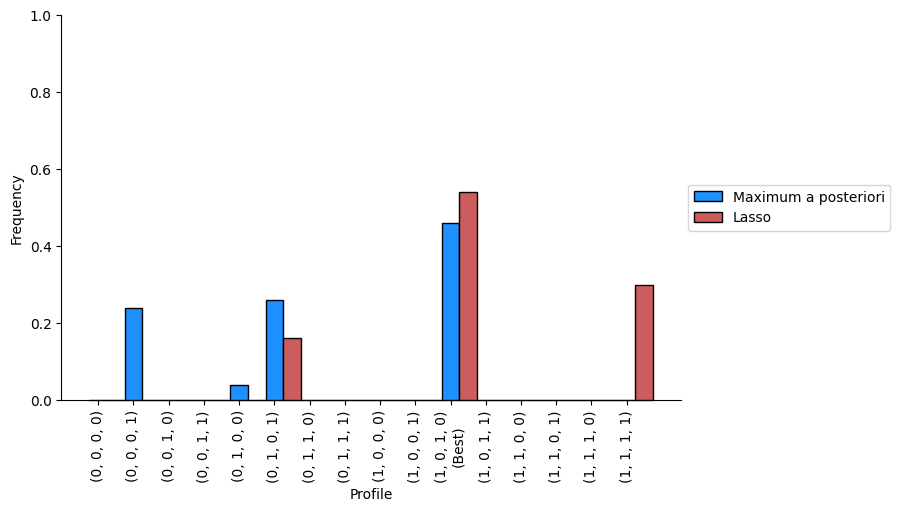

In [36]:
best_models_df = rashomon_df[rashomon_df["model_number"] == 1]

rashomon_profile_means = []
lasso_profile_means = []
ct_profile_means = []
blasso_profile_means = []
bootstrap_profile_means = []
for profile in profile_cols:
    profile_mean_col = profile + "_mean"
    rashomon_profile_means.append(np.mean(best_models_df[profile]))
    lasso_profile_means.append(np.mean(lasso_df[profile]))
    # ct_profile_means.append(np.mean(ct_df[profile]))
    blasso_profile_means.append(np.mean(blasso_df[profile]))
    bootstrap_profile_means.append(np.mean(bootstrap_df[profile]))

fig, ax = plt.subplots(figsize=(8,5))

ax.spines[['right', 'top']].set_visible(False)
profile_col_labels = deepcopy(profile_cols)
profile_col_labels[best_profile_idx] = profile_cols[best_profile_idx] + "\n(Best)"
ax.set_xticks(np.arange(len(profile_cols)), profile_col_labels, rotation=90)
ax.set_ylim(0, 1)

width = 0.5

ax.bar(np.arange(len(profile_cols)), rashomon_profile_means, width,
           color="dodgerblue", edgecolor="black", zorder=3, clip_on=False,
           label="Maximum a posteriori"
          )

ax.bar(np.arange(len(profile_cols)) + width, lasso_profile_means, width,
           color="indianred", edgecolor="black", zorder=3, clip_on=False,
           label="Lasso"
          )

# ax.bar(np.arange(len(profile_cols)) + 2*width, blasso_profile_means, width,
#            color="seagreen", edgecolor="black", zorder=3, clip_on=False,
#            label="Bayesian Lasso"
#           )

# ax.bar(np.arange(len(profile_cols)) - width, ct_profile_means, width,
#            color="forestgreen", edgecolor="black", zorder=3, clip_on=False,
#            label="Causal Trees"
#           )

ax.set_xlabel("Profile")
ax.set_ylabel("Frequency")
# ax.set_title("Best model")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/reff/frequency_chart.png", dpi=300, bbox_inches="tight")

plt.show()

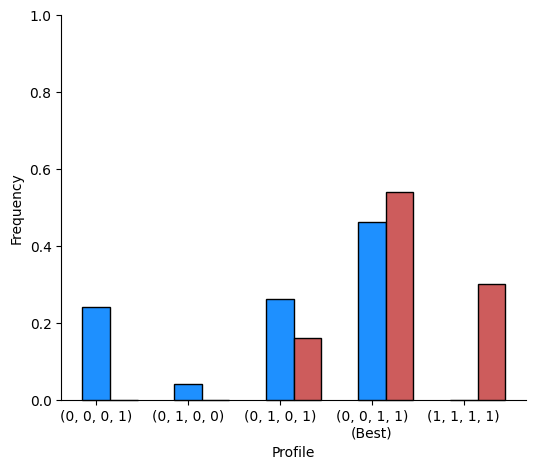

In [23]:
profiles_subset = []
rashomon_subset = []
lasso_subset = []
subset_best_idx = None
for idx, profile in enumerate(profile_cols):
    if rashomon_profile_means[idx] + lasso_profile_means[idx] == 0:
        continue
    if idx == best_profile_idx:
        subset_best_idx = len(profiles_subset)
    profiles_subset.append(profile)
    rashomon_subset.append(rashomon_profile_means[idx])
    lasso_subset.append(lasso_profile_means[idx])

fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)
profile_col_labels = deepcopy(profiles_subset)
profile_col_labels[subset_best_idx] = profile_cols[subset_best_idx] + "\n(Best)"
ax.set_xticks(np.arange(len(profiles_subset)), profile_col_labels, rotation=0)
ax.set_ylim(0, 1)

width = 0.3

ax.bar(np.arange(len(profiles_subset)), rashomon_subset, width,
           color="dodgerblue", edgecolor="black", zorder=3, clip_on=False,
           label="Maximum a posteriori"
          )

ax.bar(np.arange(len(profiles_subset)) + width, lasso_subset, width,
           color="indianred", edgecolor="black", zorder=3, clip_on=False,
           label="Lasso"
          )

# ax.bar(np.arange(len(profile_cols)) - width, ct_profile_means, width,
#            color="forestgreen", edgecolor="black", zorder=3, clip_on=False,
#            label="Causal Trees"
#           )

ax.set_xlabel("Profile")
ax.set_ylabel("Frequency")
# ax.set_title("Best model")
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/reff/frequency_chart_subsetted.png", dpi=300, bbox_inches="tight")

plt.show()

In [21]:
print("Rashomon\t", rashomon_profile_means)
print("Lasso\t\t", lasso_profile_means)

Rashomon	 [0.0, 0.24, 0.0, 0.0, 0.04, 0.26, 0.0, 0.0, 0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0]
Lasso		 [0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.54, 0.0, 0.0, 0.0, 0.0, 0.3]


## Epsilon plot

In [15]:
eps_df = rashomon_df.copy()

eps_df = eps_df.drop(profile_cols, axis=1)

eps_df["eps"] = eps_df.groupby(["n_per_pol", "sim_num"])["loss"].transform(lambda x: (x - x.min()) / x.min() * 100)

# print(np.unique(eps_df["eps"]))

# eps_levels = [-0.1, 0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
# eps_levels = [-0.1, 0, 3, 5, 7, 9, 11]
# eps_levels = [-0.1, 0, 5.2, 5.4, 5.6, 5.8, 6, 11, 12]

# eps_unique = np.unique(eps_df["eps"])
# eps_rounded = [round(x, 2) for x in eps_unique]
# eps_rounded_unique = np.unique(eps_rounded)

eps_hist = np.histogram(eps_df["eps"], bins=15)[1].tolist()
eps_levels = [-0.1] + eps_hist + [np.max(eps_df["eps"]) + 0.1]
# eps_levels = [-0.1 + np.min(eps_hist)] + eps_hist + [np.max(eps_hist) + 0.1]

# eps_levels = [-0.1] + list(eps_rounded_unique) + [np.max(eps_rounded_unique)+0.1]


# eps_hist = np.histogram(eps_df[eps_df["eps"] > 0]["eps"], bins=10)[1].tolist()
# eps_levels = [-0.1, 0] + eps_hist[1:] + [np.max(eps_df["eps"]) + 0.1]


eps_bins = eps_levels[1:]
eps_df["eps_levels"] = pd.cut(eps_df["eps"], bins=eps_levels, labels=eps_bins)

eps_df.head()

,n_per_pol,sim_num,loss,right_best_profile,wrong_best_profile,best_profile_present,model_number,eps,eps_levels
0,30,0,2.613560,1,0,1,1,0.000000,0.000000
63,30,0,2.712200,0,1,1,2,3.774193,3.810720
64,30,0,2.712964,0,1,1,3,3.803426,3.810720
39,30,0,2.713107,1,0,1,4,3.808869,3.810720
35,30,0,2.713179,1,0,1,5,3.811642,4.572864


In [16]:
plot_df = eps_df.copy()


plot_df["is_present_level"] = plot_df.groupby(
    ["n_per_pol", "sim_num", "eps_levels"], observed=False)["best_profile_present"].transform("max")

# Fill in missing eps_levels for some simulations
n_per_pol_index = [30]
sims_index = list(np.unique(eps_df["sim_num"]))
eps_index = list(eps_bins)

new_index = pd.MultiIndex.from_product([n_per_pol_index, sims_index, eps_index],
                                      names=["n_per_pol", "sim_num", "eps_levels"])
plot_df = plot_df.drop_duplicates(["n_per_pol", "sim_num", "eps_levels"])
plot_df = plot_df.set_index(["n_per_pol", "sim_num", "eps_levels"]).reindex(new_index).reset_index()

plot_df["is_present_level"] = plot_df["is_present_level"].fillna(0)


plot_df["is_present_level"] = plot_df.groupby(["n_per_pol", "sim_num"])["is_present_level"].cumsum()
plot_df.loc[plot_df["is_present_level"] > 0, "is_present_level"] = 1



plot_df["profile_rate_eps"] = plot_df.groupby(
    ["n_per_pol", "eps_levels"], observed=False)["is_present_level"].transform("mean")


plot_df = plot_df.set_index("eps_levels").dropna().reset_index()

plot_df = plot_df.drop_duplicates(["n_per_pol", "eps_levels"])
plot_df = plot_df.drop(["sim_num", "loss", "right_best_profile", "wrong_best_profile", "best_profile_present"], axis=1)
plot_df = plot_df.sort_values("eps_levels")

plot_df

,eps_levels,n_per_pol,model_number,eps,is_present_level,profile_rate_eps
0,0.000000,30,1.0,0.000000,1.0,0.46
1,3.810720,30,2.0,3.774193,1.0,0.90
2,4.572864,30,5.0,3.811642,1.0,0.92
71,7.621439,30,66.0,7.450424,1.0,0.96
87,8.383583,30,1985.0,7.621458,0.0,0.96
88,11.432159,30,1986.0,11.338074,1.0,1.00


In [20]:
# insert some additional rows

new_rows = []

eps_extended_range = np.arange(np.max(plot_df["eps_levels"]), 25, step=3)
is_present_max = np.max(plot_df["is_present_level"])
profile_eps_max = np.max(plot_df["profile_rate_eps"])

for eps_extended_i in eps_extended_range:
    new_rows.append([eps_extended_i, np.nan, np.nan, np.nan, is_present_max, profile_eps_max])

new_rows_df = pd.DataFrame(new_rows, columns=plot_df.columns)

plot_ext_df = pd.concat([plot_df, new_rows_df])
max_eps = np.max(plot_ext_df["eps_levels"])

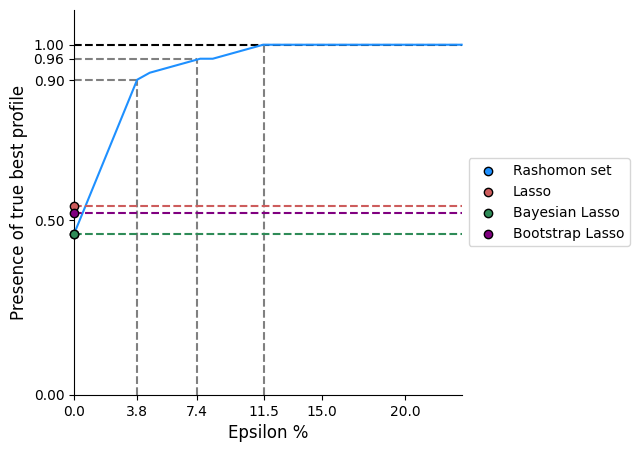

In [41]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

n = 30
colors = ["dodgerblue", "indianred", "green", "orange", "orchid", "mediumseagreen", "slateblue", "slategray"]

len_x = 10
x_horizontal = np.linspace(0, np.max(plot_ext_df["eps_levels"]), num=len_x)
y_best = np.array([1] * len_x)
# y_baseline = np.array([1/8] * len_x)
ax.plot(x_horizontal, y_best, color="black", ls="--")
ax.plot([11.5, 11.5], [0, 1], color="grey", ls="--")
ax.plot([0, 3.8], [0.9, 0.9], color="grey", ls="--")
ax.plot([3.8, 3.8], [0, 0.9], color="grey", ls="--")
ax.plot([0, 7.4], [0.96, 0.96], color="grey", ls="--")
ax.plot([7.4, 7.4], [0, 0.96], color="grey", ls="--")

    
ax.plot(plot_ext_df["eps_levels"], plot_ext_df["profile_rate_eps"],
        color=colors[0], zorder=3.1, clip_on=False,
        # label=f"{n}"
       )

ax.plot([0, max_eps], [lasso_profile_means[best_profile_idx], lasso_profile_means[best_profile_idx]],
         color="indianred", zorder=3.1, clip_on=False, ls="--"
        )

ax.plot([0, max_eps], [blasso_profile_means[best_profile_idx], blasso_profile_means[best_profile_idx]],
         color="seagreen", zorder=3.1, clip_on=False, ls="--"
        )

ax.plot([0, max_eps], [bootstrap_profile_means[best_profile_idx], bootstrap_profile_means[best_profile_idx]],
         color="purple", zorder=3.1, clip_on=False, ls="--"
        )

ax.scatter(plot_ext_df["eps_levels"].iloc[0], plot_ext_df["profile_rate_eps"].iloc[0],
           color=colors[0], edgecolor="black",
           label="Rashomon set",
           zorder=3.1, clip_on=False)

ax.scatter([0], lasso_profile_means[best_profile_idx],
           color="indianred", edgecolor="black",
           label="Lasso",
           zorder=3.1, clip_on=False)

ax.scatter([0], blasso_profile_means[best_profile_idx],
           color="seagreen", edgecolor="black",
           label="Bayesian Lasso",
           zorder=3.1, clip_on=False)

ax.scatter([0], bootstrap_profile_means[best_profile_idx],
           color="purple", edgecolor="black",
           label="Bootstrap Lasso",
           zorder=3.1, clip_on=False)

# ax.scatter([0], ct_profile_means[best_profile_idx],
#            color="forestgreen", edgecolor="black",
#            label="Causal Trees",
#            zorder=3.1, clip_on=False)

# ax.set_xscale("log")
ax.set_xlim(0, max_eps)
ax.set_xlabel("Epsilon %", fontsize=12)
ax.set_xticks([0, 3.8, 7.4, 11.5, 15, 20])

ax.set_ylim(0, 1.1)
ax.set_yticks([0, 0.5, 0.9, 0.96, 1])
ax.set_ylabel("Presence of true best profile", fontsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))#, title="Samples per variant")

# plt.savefig("../Figures/reff/best_profile_rate_no_legend.png", dpi=300, bbox_inches="tight")
plt.show()